# Notebook 2: Data Processing

The objective of this project is to create an image classification model by classifying x-rays whether someone has pneumonia or not. The tutorial I followed to run a convolutional neural network to identify whether one has pneumonia or not can be found from [tensorflow.com](https://www.tensorflow.org/tutorials/images/classification)



In [1]:
import glob
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# For reproducible results:
from numpy.random import seed
seed(1)
%matplotlib inline

The dataset has the following directory structure:

<pre>
<b>data</b>
|__ <b>train</b>
    |______ <b>PNEUMONIA</b>: [pneumonia_0.jpg, pneumonia_1.jpg, pneumonia_2.jpg ....]
    |______ <b>NORMAL</b>: [normal_0.jpg, normal_1.jpg, normal_2.jpg ...]
|__ <b>test</b>
    |______ <b>PNEUMONIA</b>: [pneumonia_0.jpg, pneumonia_1.jpg, pneumonia_2.jpg ....]
    |______ <b>NORMAL</b>: [normal_0.jpg, normal_1.jpg, normal_2.jpg ...]
</pre>

In [2]:
train_directory = '../data/train/'
test_directory = '../data/test/'

normal_tr = glob.glob('../data/train/NORMAL/*.jpeg')
pneumonia_tr = glob.glob('../data/train/PNEUMONIA/*.jpeg')

normal_test = glob.glob('../data/test/NORMAL/*.jpeg')
pneumonia_test = glob.glob('../data/test/PNEUMONIA/*.jpeg')


print(f"Total training normal images: {len(normal_tr)}")
print(f"Total training pneumonia images: {len(pneumonia_tr)}")
print(f"Total test normal images: {len(normal_test)}")
print(f"Total train normal images: {len(pneumonia_test)}")
print("--")
print("Total training images:", len(glob.glob('../data/train/*/*.jpeg')))
print("Total test images:", len(glob.glob('../data/test/*/*.jpeg')))

Total training normal images: 1341
Total training pneumonia images: 3875
Total test normal images: 242
Total train normal images: 398
--
Total training images: 5216
Total test images: 640


## Data Processing and Augmentation

The images now must be processed. As mentioned before in Notebook 1, each images' resolution, pixel width and height, zoom, and angle is different, so the images have to be normalized by using keras' `ImageDataGenerator`.

`ImageDataGenerator` will transform images to floating point tensors, which can the be inputted into the neural network. The following steps will be performed:
1. Images will be read in
2. Images will be resized to [224x224 pixels](https://datascience.stackexchange.com/questions/16601/reason-for-square-images-in-deep-learning) because many models such as VGG and ResNet like squares apparently.<font color = 'red'>***</font>
    
3. Images will then be converted to floating point tensors
4. Tensors will be rescaled from values between 0 and 255 to values between 0 and 1 because small input values are better to train for neural networks.

The data augmentation portion is necessary to create more inputs/observations to train the model. More training data will be generated by reshaping and modifying existing training images. The following will be applied for augmentation:

1. `horizontal_flip = True` - enough said
2. `rotation_range = 30` - randomly rotate an image by 30 degrees
3. `zoom_range=0.3` - randomly zoom into an image up to 30%


<font color = 'red'>***</font> More in depth explanation: Increasing input image size will lead to an increase in noise and variance that will require the network to deal with more processing, such asmore pooling or layers.
    
Documentation source for pre-processing - [keras - preprocessing](https://keras.io/preprocessing/image/)

Let's observe an example of a `horizontal_flip` parameter in action:

In [3]:
train_img_gen = ImageDataGenerator(rescale=1./255, 
                                   horizontal_flip = True)

In [4]:
# just to demonstrate the power of horziontal_flip, we are selecting an arbitrary batch_size = 32
train_data_horiz = train_img_gen = train_img_gen.flow_from_directory(batch_size = 32,
                                                               directory = train_directory,
                                                               shuffle = True,
                                                               target_size = (244,244),
                                                               class_mode = 'binary'
                                                              )

Found 5216 images belonging to 2 classes.


In [5]:
horizontal_img = [train_data_horiz[0][0][0] for _ in range(5)]

In [6]:
def plot_image(image_array):
    fig = plt.figure(figsize=(25, 10))

    rows, columns = 1, 5

    for i in range(1, columns*rows +1):
        img = image_array[i-1]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img, cmap = 'gray')
        plt.axis('off');

    plt.tight_layout()    
    plt.show()

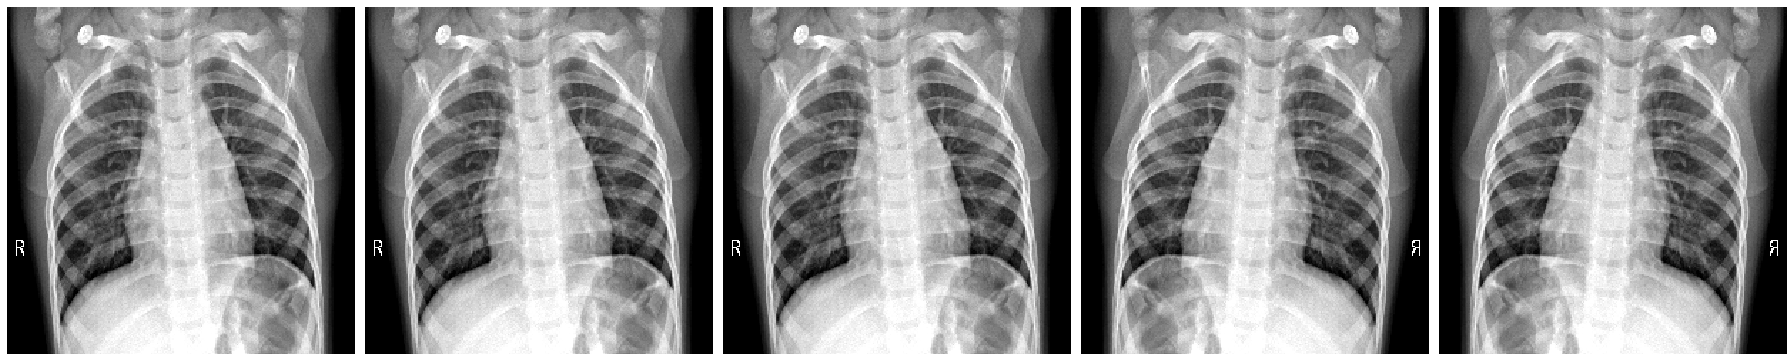

In [7]:
plot_image(horizontal_img)

Some are flipped, some are not!

Let's observe an example of a `rotation_range` parameter in action:

Found 5216 images belonging to 2 classes.


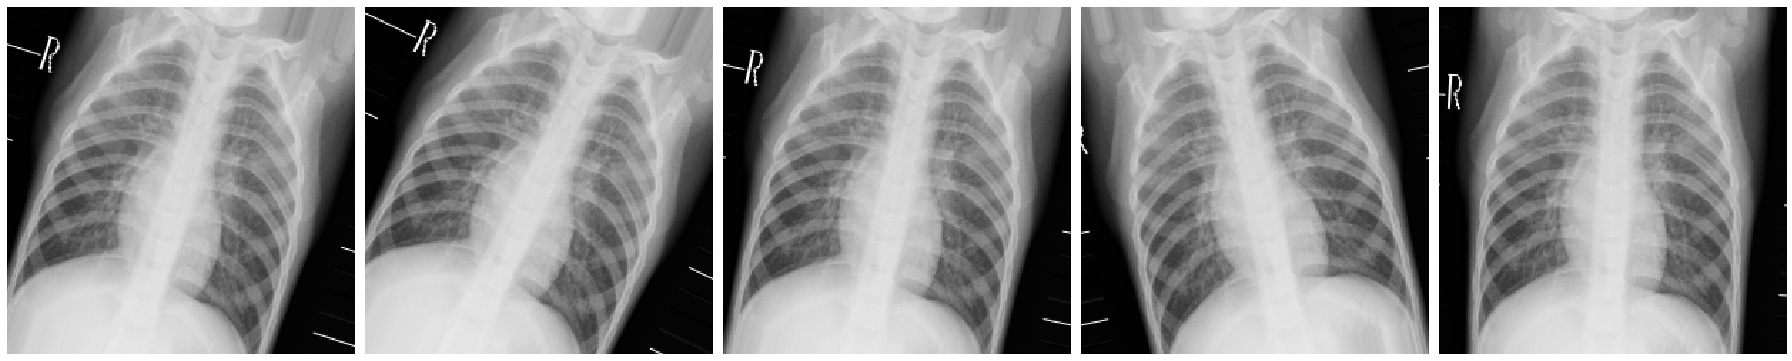

In [8]:
train_img_gen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range = 30)

train_data_rotate = train_img_gen = train_img_gen.flow_from_directory(batch_size = 32,
                                                               directory = train_directory,
                                                               shuffle = True,
                                                               target_size = (244,244),
                                                               class_mode = 'binary'
                                                              )
rotation_img = [train_data_rotate[0][0][0] for _ in range(5)]
plot_image(rotation_img)

As you can see, images have been rotated by random 30 degree angles.

Let's observe an example of a `zoom_range` parameter in action:

Found 5216 images belonging to 2 classes.


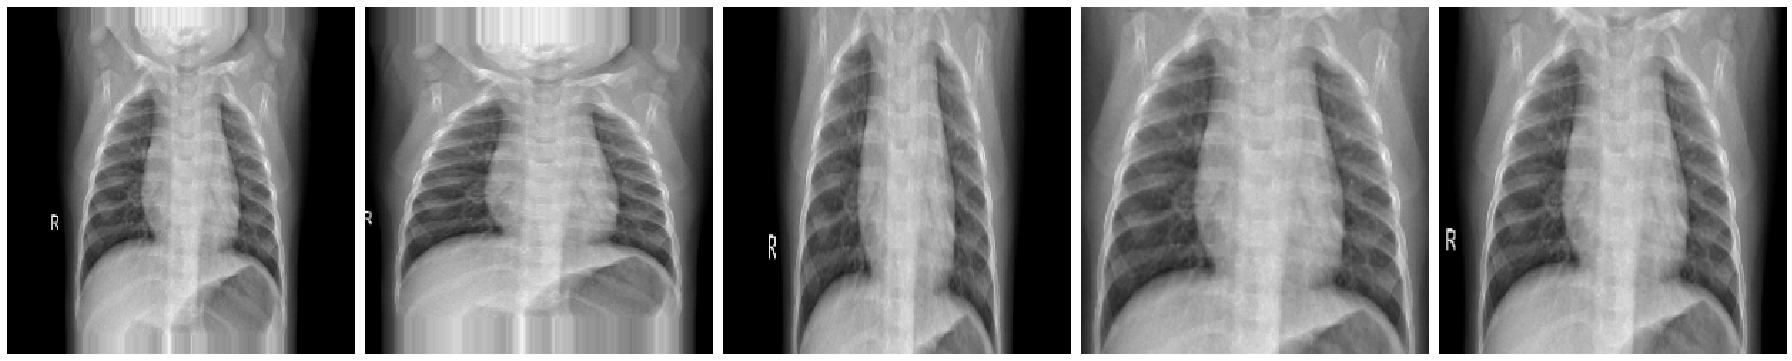

In [9]:
train_img_gen = ImageDataGenerator(rescale=1./255, 
                                   zoom_range = .30)

train_data_zoom = train_img_gen = train_img_gen.flow_from_directory(batch_size = 32,
                                                               directory = train_directory,
                                                               shuffle = True,
                                                               target_size = (244,244),
                                                               class_mode = 'binary'
                                                              )
zoom_img = [train_data_zoom[0][0][0] for _ in range(5)]
plot_image(zoom_img)

Pretty cool, now I'm going to apply all three augmentations into one for a final `train_data` that contains all of the transformed floating point tensors.

Found 5216 images belonging to 2 classes.


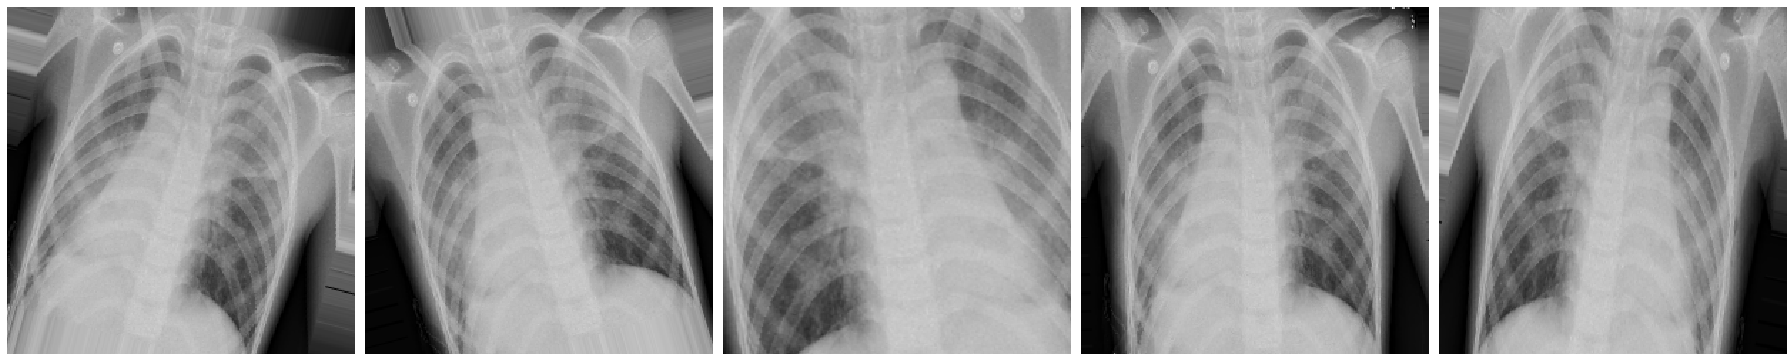

In [10]:
train_img_gen = ImageDataGenerator(rescale=1./255, 
                                   horizontal_flip = True,
                                   rotation_range = 30,
                                   zoom_range = .30)

train_data = train_img_gen = train_img_gen.flow_from_directory(batch_size = 32,
                                                               directory = train_directory,
                                                               shuffle = True,
                                                               target_size = (244,244),
                                                               class_mode = 'binary'
                                                              )
train_img = [train_data[0][0][0] for _ in range(5)]
plot_image(train_img)

Now the test images will be processed, but there will be no augmentation necessary because augmentation is to increase more training samples. 

Found 640 images belonging to 2 classes.


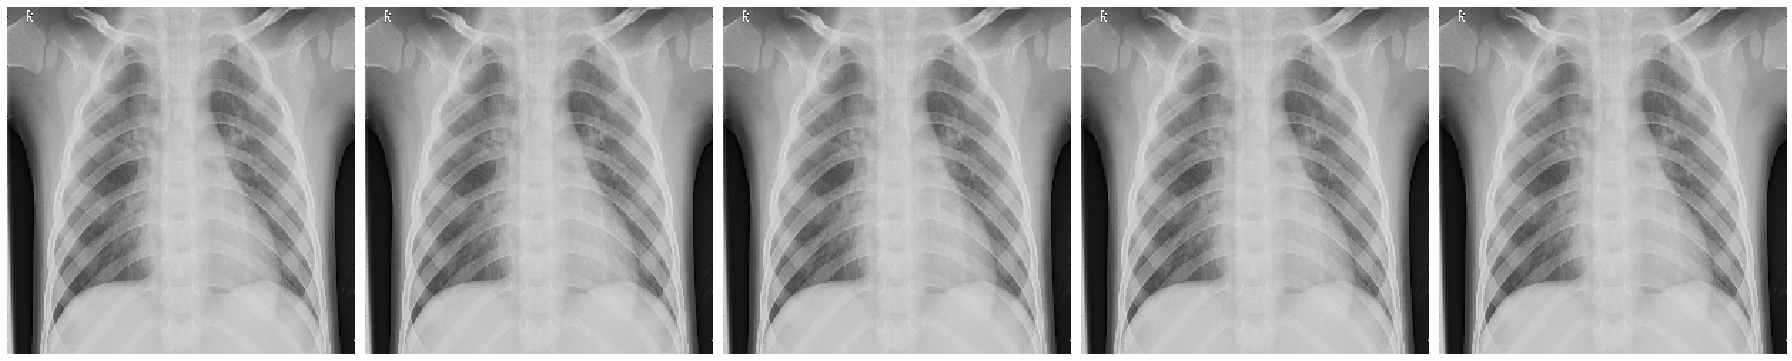

In [11]:
test_img_gen = ImageDataGenerator(rescale=1./255)

test_data = test_img_gen.flow_from_directory(batch_size = 32,
                                             directory = test_directory,
                                             shuffle = True,
                                             target_size = (244,244),
                                             class_mode = 'binary'
                                                              )
test_img = [test_data[0][0][0] for _ in range(5)]
plot_image(test_img)

In [12]:
type(test_data)

keras_preprocessing.image.directory_iterator.DirectoryIterator

I will now save `train_data` and `test_data` as a py.file for the third notebook's CNN modeling process.

In [14]:
%%writefile '../assets/tensor_data.py'

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_directory = '../data/train/'
test_directory = '../data/test/'

train_img_gen = ImageDataGenerator(rescale=1./255, 
                                   horizontal_flip = True,
                                   rotation_range = 30,
                                   zoom_range = .30)

train_data = train_img_gen = train_img_gen.flow_from_directory(batch_size = 32,
                                                               directory = train_directory,
                                                               shuffle = True,
                                                               target_size = (244,244),
                                                               class_mode = 'binary'
                                                              )
test_img_gen = ImageDataGenerator(rescale=1./255)

test_data = test_img_gen.flow_from_directory(batch_size = 32,
                                             directory = test_directory,
                                             shuffle = True,
                                             target_size = (244,244),
                                             class_mode = 'binary'
                                                              )

Overwriting ../assets/tensor_data.py
